In [ ]:
library(rio)
library(tidyverse)
library(ggtern)
library(smwrData)
library(smwrBase)
library(smwrGraphs)

In [2]:
# Load ggplot theme
source("../../GLab_ggplot2_theme/glab_theme.r")

# Load Giggenbach and Langelier-Ludwig plot
source("../R/giggenbach-plot.R")
source("../R/langelier-ludwig-plot.R")

In [3]:
PROJECT_NAME = "ARG23"

DATA_DIR = file.path(
    "../data/",
    PROJECT_NAME
)

## Decription of the input files

* **DIC data** - *ARG23.xlsx*

* **Alkalinity data** - *ARG23_dataset.xlsx*

* **IC data** - *Anioni_Cationi_ARG23.xlsx*

* **ICP-MS data** - *ARG23_dil1at10.xlsx*

## DIC analysis

In [4]:
dic_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23.xlsx"
    ),
    skip=4
)

dic_df = dic_df %>%
    # Drop NA rows
    drop_na(Name) %>%
    # Format "Sample Type"
    mutate(`Sample Type`=str_replace_all(
            string=`Sample Type`,
            pattern="\\(|\\)",
            replacement=""
        )
    ) %>%
    # Convert to numeric
    mutate(
        `Height (nA)`=as.numeric(`Height (nA)`),
        `δ¹³C (Gas)`=as.numeric(`δ¹³C (Gas)`)
    ) %>%
    # Group by name and calculate the mean
    group_by(Name) %>%
    summarise(
        Height_mean=mean(`Height (nA)`),
        DeltaC13_mean=mean(`δ¹³C (Gas)`),
        DeltaC13_sd=sd(`δ¹³C (Gas)`) # TODO: check use of SE
    )

dic_df = dic_df %>%
    # Natural sort by name
    slice(stringr::str_order(dic_df$Name, numeric=TRUE)) %>%
    # Transform to factor for plotting the samples in the correct order
    mutate(Name=factor(Name, levels=Name))

dic_df

Name,Height_mean,DeltaC13_mean,DeltaC13_sd
<fct>,<dbl>,<dbl>,<dbl>
ARG23_1,6.4190218,-3.4409935,0.1359016
ARG23_2,4.0301275,-5.5271253,0.2716068
ARG23_3,5.4543274,-3.1768285,0.8068695
ARG23_4,3.5758961,-9.9798606,0.4742499
ARG23_5,1.8756161,-5.9922322,0.7973183
ARG23_6,12.8719853,-2.6227354,0.5387774
ARG23_7,1.4093049,-6.6174893,0.7180623
ARG23_8,4.7544556,-5.8113600,0.2032612
ARG23_9,2.6648682,-4.2482822,0.1525767


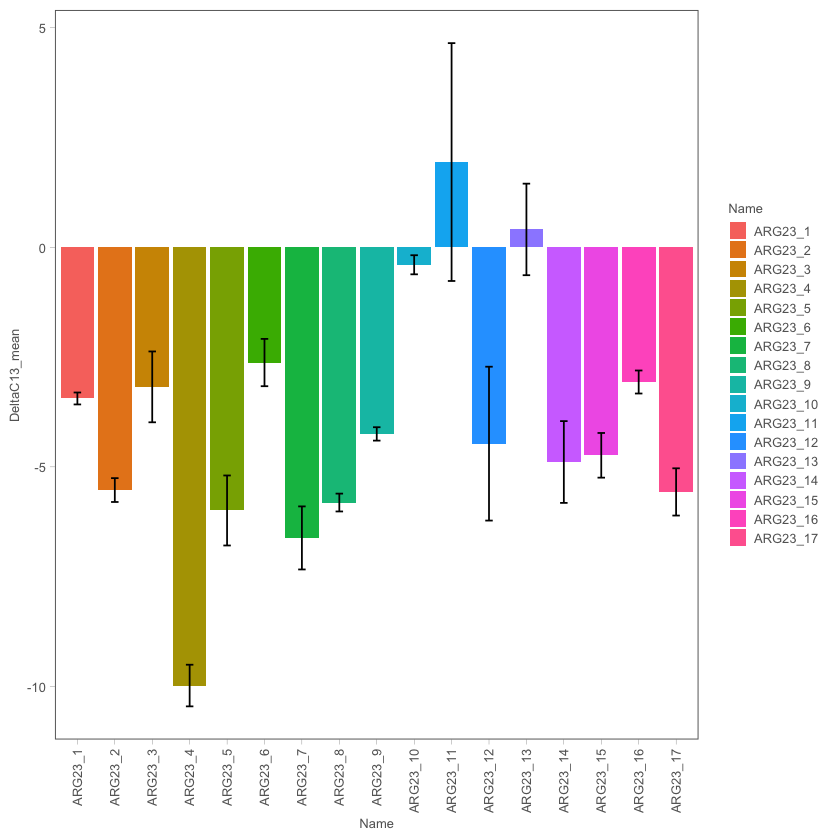

In [5]:
plot_dic = ggplot(
        data=dic_df,
        aes(
            x=Name,
            y=DeltaC13_mean,
            fill=Name
        )
    ) +
    geom_col() +
    geom_errorbar(
        aes(
            ymin=DeltaC13_mean - DeltaC13_sd,
            ymax=DeltaC13_mean + DeltaC13_sd
        ),
        width=.2
    ) +
    theme_glab() +
    # Rotate X axis labels
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

plot_dic

## IC analysis

In [11]:
ic_df = import(
    file=file.path(
        DATA_DIR,
        "Anioni_Cationi_ARG23.xlsx"
    )
)

ic_df = ic_df %>%
    # Remove controls
    drop_na(Expedition) %>%
    # Remove time column
    select(-`Determination start`) %>%
    # Rename ID column
    rename(ID=Ident)

# Merge anions and cations (see https://stackoverflow.com/a/45518649)
ic_df = ic_df %>%
    group_by(ID) %>%
    fill(everything(), .direction = "downup") %>%
    slice(1)

# Rename columns (see https://stackoverflow.com/a/23518906)

# Create the mapping for renaming the columns
ic_columns_map = as.vector(colnames(ic_df))
names(ic_columns_map) = str_extract(
    string=colnames(ic_df),
    pattern="(?<=[Anions|Cations]\\.)(.+)(?=\\.Concentration)"
)

# Deselect the original columns
ic_columns_map = ic_columns_map[!is.na(names(ic_columns_map))]

# Finally, rename the columns using the mapping
ic_df = ic_df %>%
    rename(all_of(ic_columns_map))

# Add bicarbonate data
bicarb_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dataset.xlsx"
    ),
    sheet="env_data"
)
bicarb_df = bicarb_df %>%
    select(ID, hco3) %>%
    rename(Bicarbonate=hco3)

ic_df = left_join(
    x=ic_df,
    y=bicarb_df,
    by="ID"
)


ic_df

ID,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,Ammonium,Potassium,Magnesium,Calcium,Bicarbonate
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LB,ARG23,1954.90,7950.703,NA,NA,2197296.00,NA,2121.135,5372.504,87.938,434.672,52.737,279.845,1006.50
LV,ARG23,3863.25,22813.620,NA,NA,2070508.00,NA,3553.992,12257.730,214.816,1652.636,896.096,1327.956,808.86
OY,ARG23,20.18,86.709,NA,NA,13386.74,NA,348.986,154.226,1.182,3.939,6.791,13.944,318.42
PI,ARG23,1991.83,7571.802,NA,NA,2278402.00,NA,709.547,5223.494,69.399,424.462,139.712,296.258,2763.30
VA,ARG23,19.79,8.021,3.593,NA,13832.41,NA,242.493,12.587,0.803,7.134,14.733,18.100,40.26


#### Giggenbach diagram

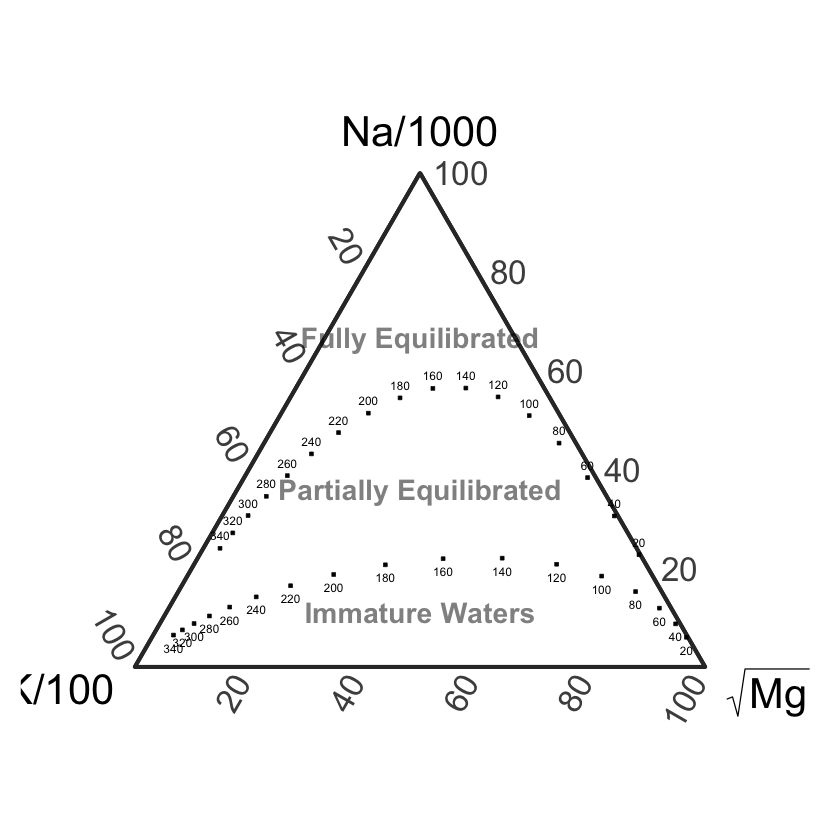

In [7]:
plot_base_gigg()

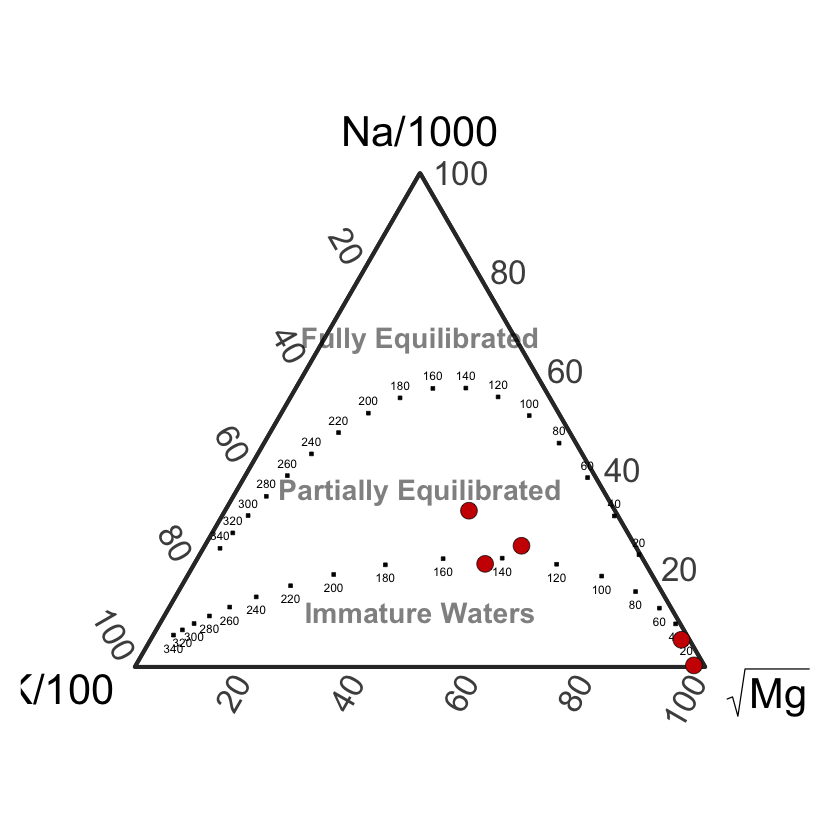

In [8]:
plot_base_gigg() +
    geom_point(
        data=ic_df,
        size=4.5,
        shape=21,
        fill="red3",
        stroke=.3
    )

#### Langelier-Ludwig diagram

In [12]:
# Calculate 
ic_df = ic_df %>%
    # WARNING: concentrations must be in mg/L!!!
    mutate(
        HCO3.meq=conc2meq(Bicarbonate, "bicarb"),
        Cl.meq=conc2meq(Chloride, "chloride"),
        SO4.meq=conc2meq(Sulfate, "sulfate"),
        Na.meq=conc2meq(Sodium, "sodium"),
        K.meq=conc2meq(Potassium, "potassium"),
        Ca.meq=conc2meq(Calcium, "calcium"),
        Mg.meq=conc2meq(Magnesium, "magnesium")
    )

ic_df

ID,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,⋯,Magnesium,Calcium,Bicarbonate,HCO3.meq,Cl.meq,SO4.meq,Na.meq,K.meq,Ca.meq,Mg.meq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LB,ARG23,1954.90,7950.703,NA,NA,2197296.00,NA,2121.135,5372.504,⋯,52.737,279.845,1006.50,16.4965350,224.2893316,44.162031,233.7039240,11.1189098,13.9642655,4.3397277
LV,ARG23,3863.25,22813.620,NA,NA,2070508.00,NA,3553.992,12257.730,⋯,896.096,1327.956,808.86,13.2572154,643.5722202,73.994113,533.2112550,42.2744289,66.2650044,73.7397398
OY,ARG23,20.18,86.709,NA,NA,13386.74,NA,348.986,154.226,⋯,6.791,13.944,318.42,5.2189038,2.4460609,7.265889,6.7088310,0.1007596,0.6958056,0.5588314
PI,ARG23,1991.83,7571.802,NA,NA,2278402.00,NA,709.547,5223.494,⋯,139.712,296.258,2763.30,45.2904870,213.6005344,14.772769,227.2219890,10.8577380,14.7832742,11.4969005
VA,ARG23,19.79,8.021,3.593,NA,13832.41,NA,242.493,12.587,⋯,14.733,18.100,40.26,0.6598614,0.2262724,5.048704,0.5475345,0.1824877,0.9031900,1.2123786


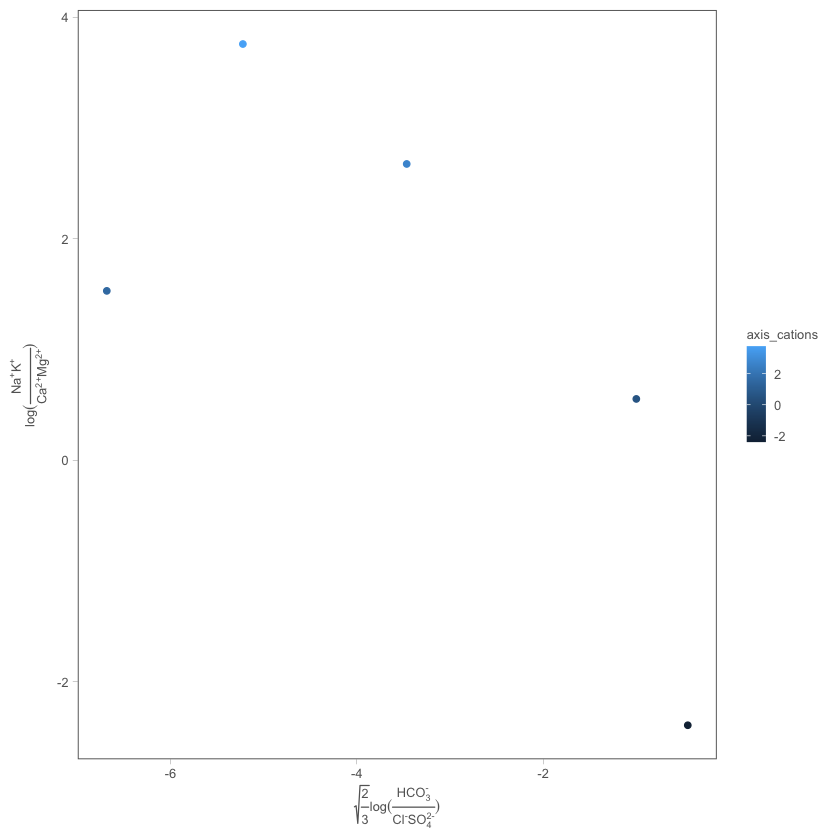

In [13]:
plot_ll(ic_df) +
    theme_glab()

#### Piper diagram

Warning message in title(...):
“font family 'USGS' not found in PostScript font database”
Warning message in title(...):
“font family 'USGS' not found in PostScript font database”


Warning message in text.default(x = x.along, y = rep(min, num.labels), labels = axis.labels, :
“font family 'USGS' not found in PostScript font database”
Warning message in text.default(x = x.along, y = rep(min, num.labels), labels = axis.labels, :
“font family 'USGS' not found in PostScript font database”
Warning message in text.default(x = x.along, y = rep(min, num.labels), labels = axis.labels, :
“font family 'USGS' not found in PostScript font database”
Warning message in text.default(x = x.along, y = rep(min, num.labels), labels = axis.labels, :
“font family 'USGS' not found in PostScript font database”
Warning message in text.default(x = x.along, y = rep(min, num.labels), labels = axis.labels, :
“font family 'USGS' not found in PostScript font database”
Warning message in text.default(x = x.along, y = rep(min, num.labels), labels = axis.labels, :
“font family 'USGS' not found in PostScript font database”
Warning message in text.default(x = x.along, y = rep(min, num.labels), label

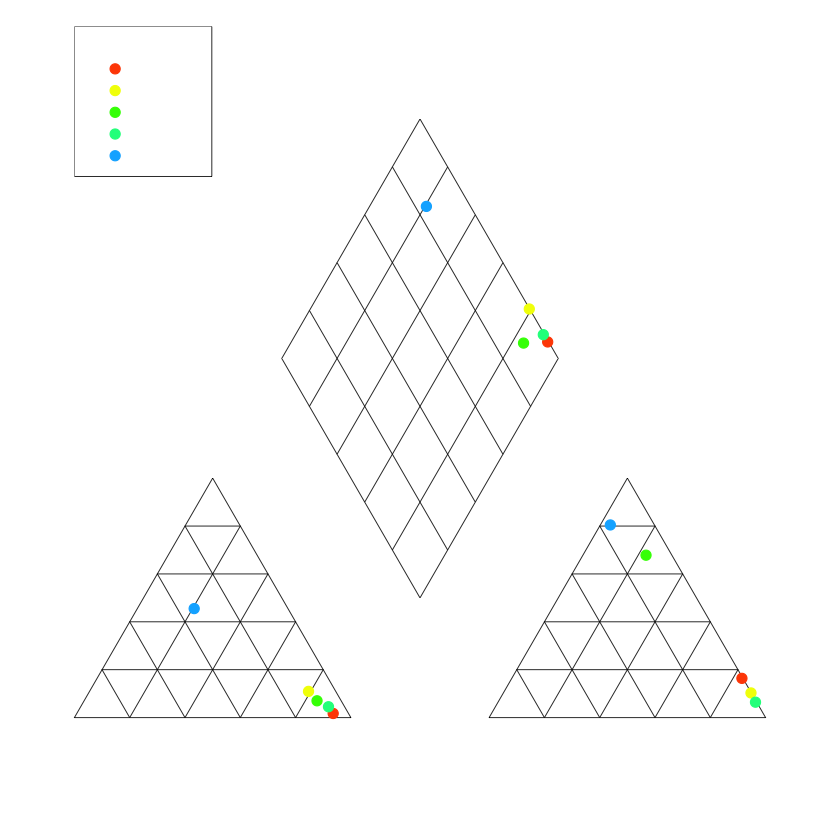

In [ ]:
smwrGraphs::piperPlot(
        xCat=ic_df$Ca.meq,
        yCat=ic_df$Mg.meq,
        zCat=ic_df$Na.meq,
        xAn=ic_df$Cl.meq,
        yAn=ic_df$HCO3.meq,
        zAn=ic_df$SO4.meq,
        Plot=list(
            name=ic_df$ID,
            color=setColor(ic_df$ID)
        ),
        zCat.title="Sodium",
        xAn.title="Chloride",
        yAn.title="Bicarbonate"
    ) %>%
    addExplanation(
        where="ul",
        title="Piper diagram"
    )


## ICP-MS analysis

In [ ]:
icp_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dil1at10.xlsx"
    )
)